<a href="https://colab.research.google.com/github/FaraazArsath/Akaike-Assignment/blob/main/EDA_VBPE_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
import numpy as np
import os
import sys
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
import random
import cv2
!pip install scipy
from scipy.stats import pearsonr

In [4]:
# Loading metadata CSV
csv_path = '/content/drive/MyDrive/sonocare/df_video_metadata_demog.csv'
df = pd.read_csv(csv_path)
df.head()

,id,spo2,temperature,bps,bpd,pulse,age,height,weight,gender,...,category,Filename,Filepath,Duration (s),Size (bytes),Bitrate (bps),Format,Size (MB),Size (GB),Mbps (megabits por segundo)
0,IN585,NaN,NaN,147,80,68,60,150,52.0,Female,...,9,Copy of IN585.mp4,/content/drive/MyDrive/sonocare/V-BPE Dataset ...,120.234,202523444,13475286,"mov,mp4,m4a,3gp,3g2,mj2",193.141407,0.188615,13.475286
1,IN602,NaN,NaN,138,77,101,52,146,50.0,Female,...,8,Copy of IN602.mp4,/content/drive/MyDrive/sonocare/V-BPE Dataset ...,121.017,384817169,25438883,"mov,mp4,m4a,3gp,3g2,mj2",366.990251,0.358389,25.438883
2,IN606,NaN,NaN,117,85,70,32,163,73.0,Female,...,4,Copy of IN606.mp4,/content/drive/MyDrive/sonocare/V-BPE Dataset ...,123.017,591266093,38451016,"mov,mp4,m4a,3gp,3g2,mj2",563.875287,0.550659,38.451016
3,IN614,NaN,NaN,132,84,90,48,163,70.0,Female,...,7,Copy of IN614.mp4,/content/drive/MyDrive/sonocare/V-BPE Dataset ...,122.967,628003954,40856747,"mov,mp4,m4a,3gp,3g2,mj2",598.911242,0.584874,40.856747
4,IN660,NaN,NaN,164,84,76,75,167,55.0,Male,...,12,Copy of IN660.mp4,/content/drive/MyDrive/sonocare/V-BPE Dataset ...,120.734,220245120,14593742,"mov,mp4,m4a,3gp,3g2,mj2",210.042114,0.205119,14.593742


In [14]:
# Checking data types and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           143 non-null    object 
 1   spo2                         0 non-null      float64
 2   temperature                  0 non-null      float64
 3   bps                          143 non-null    int64  
 4   bpd                          143 non-null    int64  
 5   pulse                        143 non-null    int64  
 6   age                          143 non-null    int64  
 7   height                       143 non-null    int64  
 8   weight                       143 non-null    float64
 9   gender                       143 non-null    object 
 10  bmi                          143 non-null    float64
 11  race                         143 non-null    object 
 12  category                     143 non-null    int64  
 13  Filename            

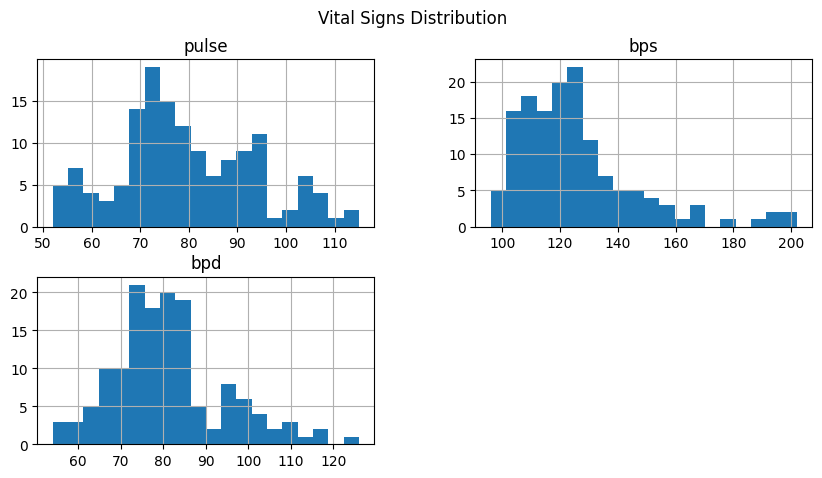

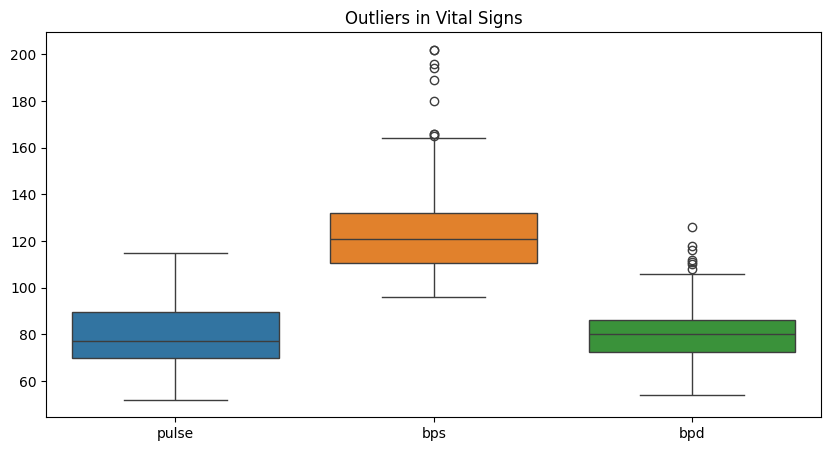

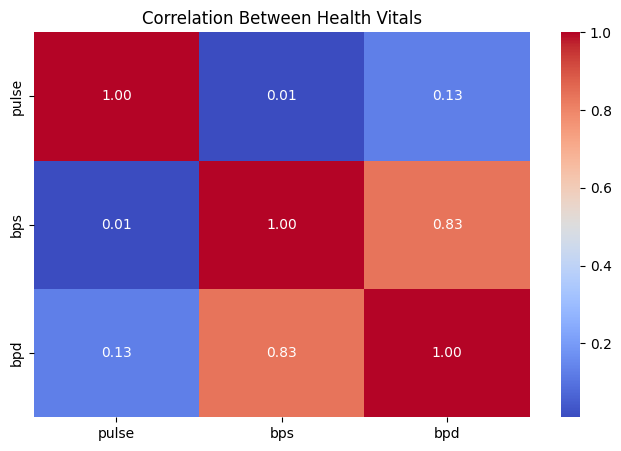

In [18]:
# Vital Signs Distribution & Correlation
vital_columns = ['pulse', 'bps', 'bpd']

# Histograms
df[vital_columns].hist(figsize=(10, 5), bins=20)
plt.suptitle("Vital Signs Distribution")
plt.show()

# Boxplots for Outlier Detection
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[vital_columns])
plt.title("Outliers in Vital Signs")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df[vital_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Health Vitals")
plt.show()


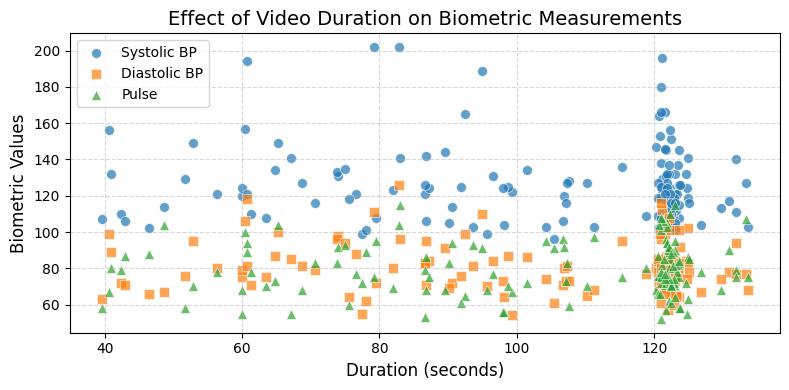

In [12]:
# Scatter plot: Duration vs. biometric signs
plt.figure(figsize=(8, 4))

sns.scatterplot(x=df['Duration (s)'], y=df['bps'], label='Systolic BP', marker='o', s=50, alpha=0.7)
sns.scatterplot(x=df['Duration (s)'], y=df['bpd'], label='Diastolic BP', marker='s', s=50, alpha=0.7)
sns.scatterplot(x=df['Duration (s)'], y=df['pulse'], label='Pulse', marker='^', s=50, alpha=0.7)

plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Biometric Values', fontsize=12)
plt.title('Effect of Video Duration on Biometric Measurements', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

**Key Observation**

As video duration increases, both systolic and diastolic BP, along with pulse rate, seem to rise, particularly after 100 seconds.
There may be a threshold around 60-100 seconds, where biometrics appear less stable before ramping up at higher durations.

Several outliers exist, especially for systolic BP at lower durations and diastolic BP at higher durations, suggesting individual variability in response to video duration.


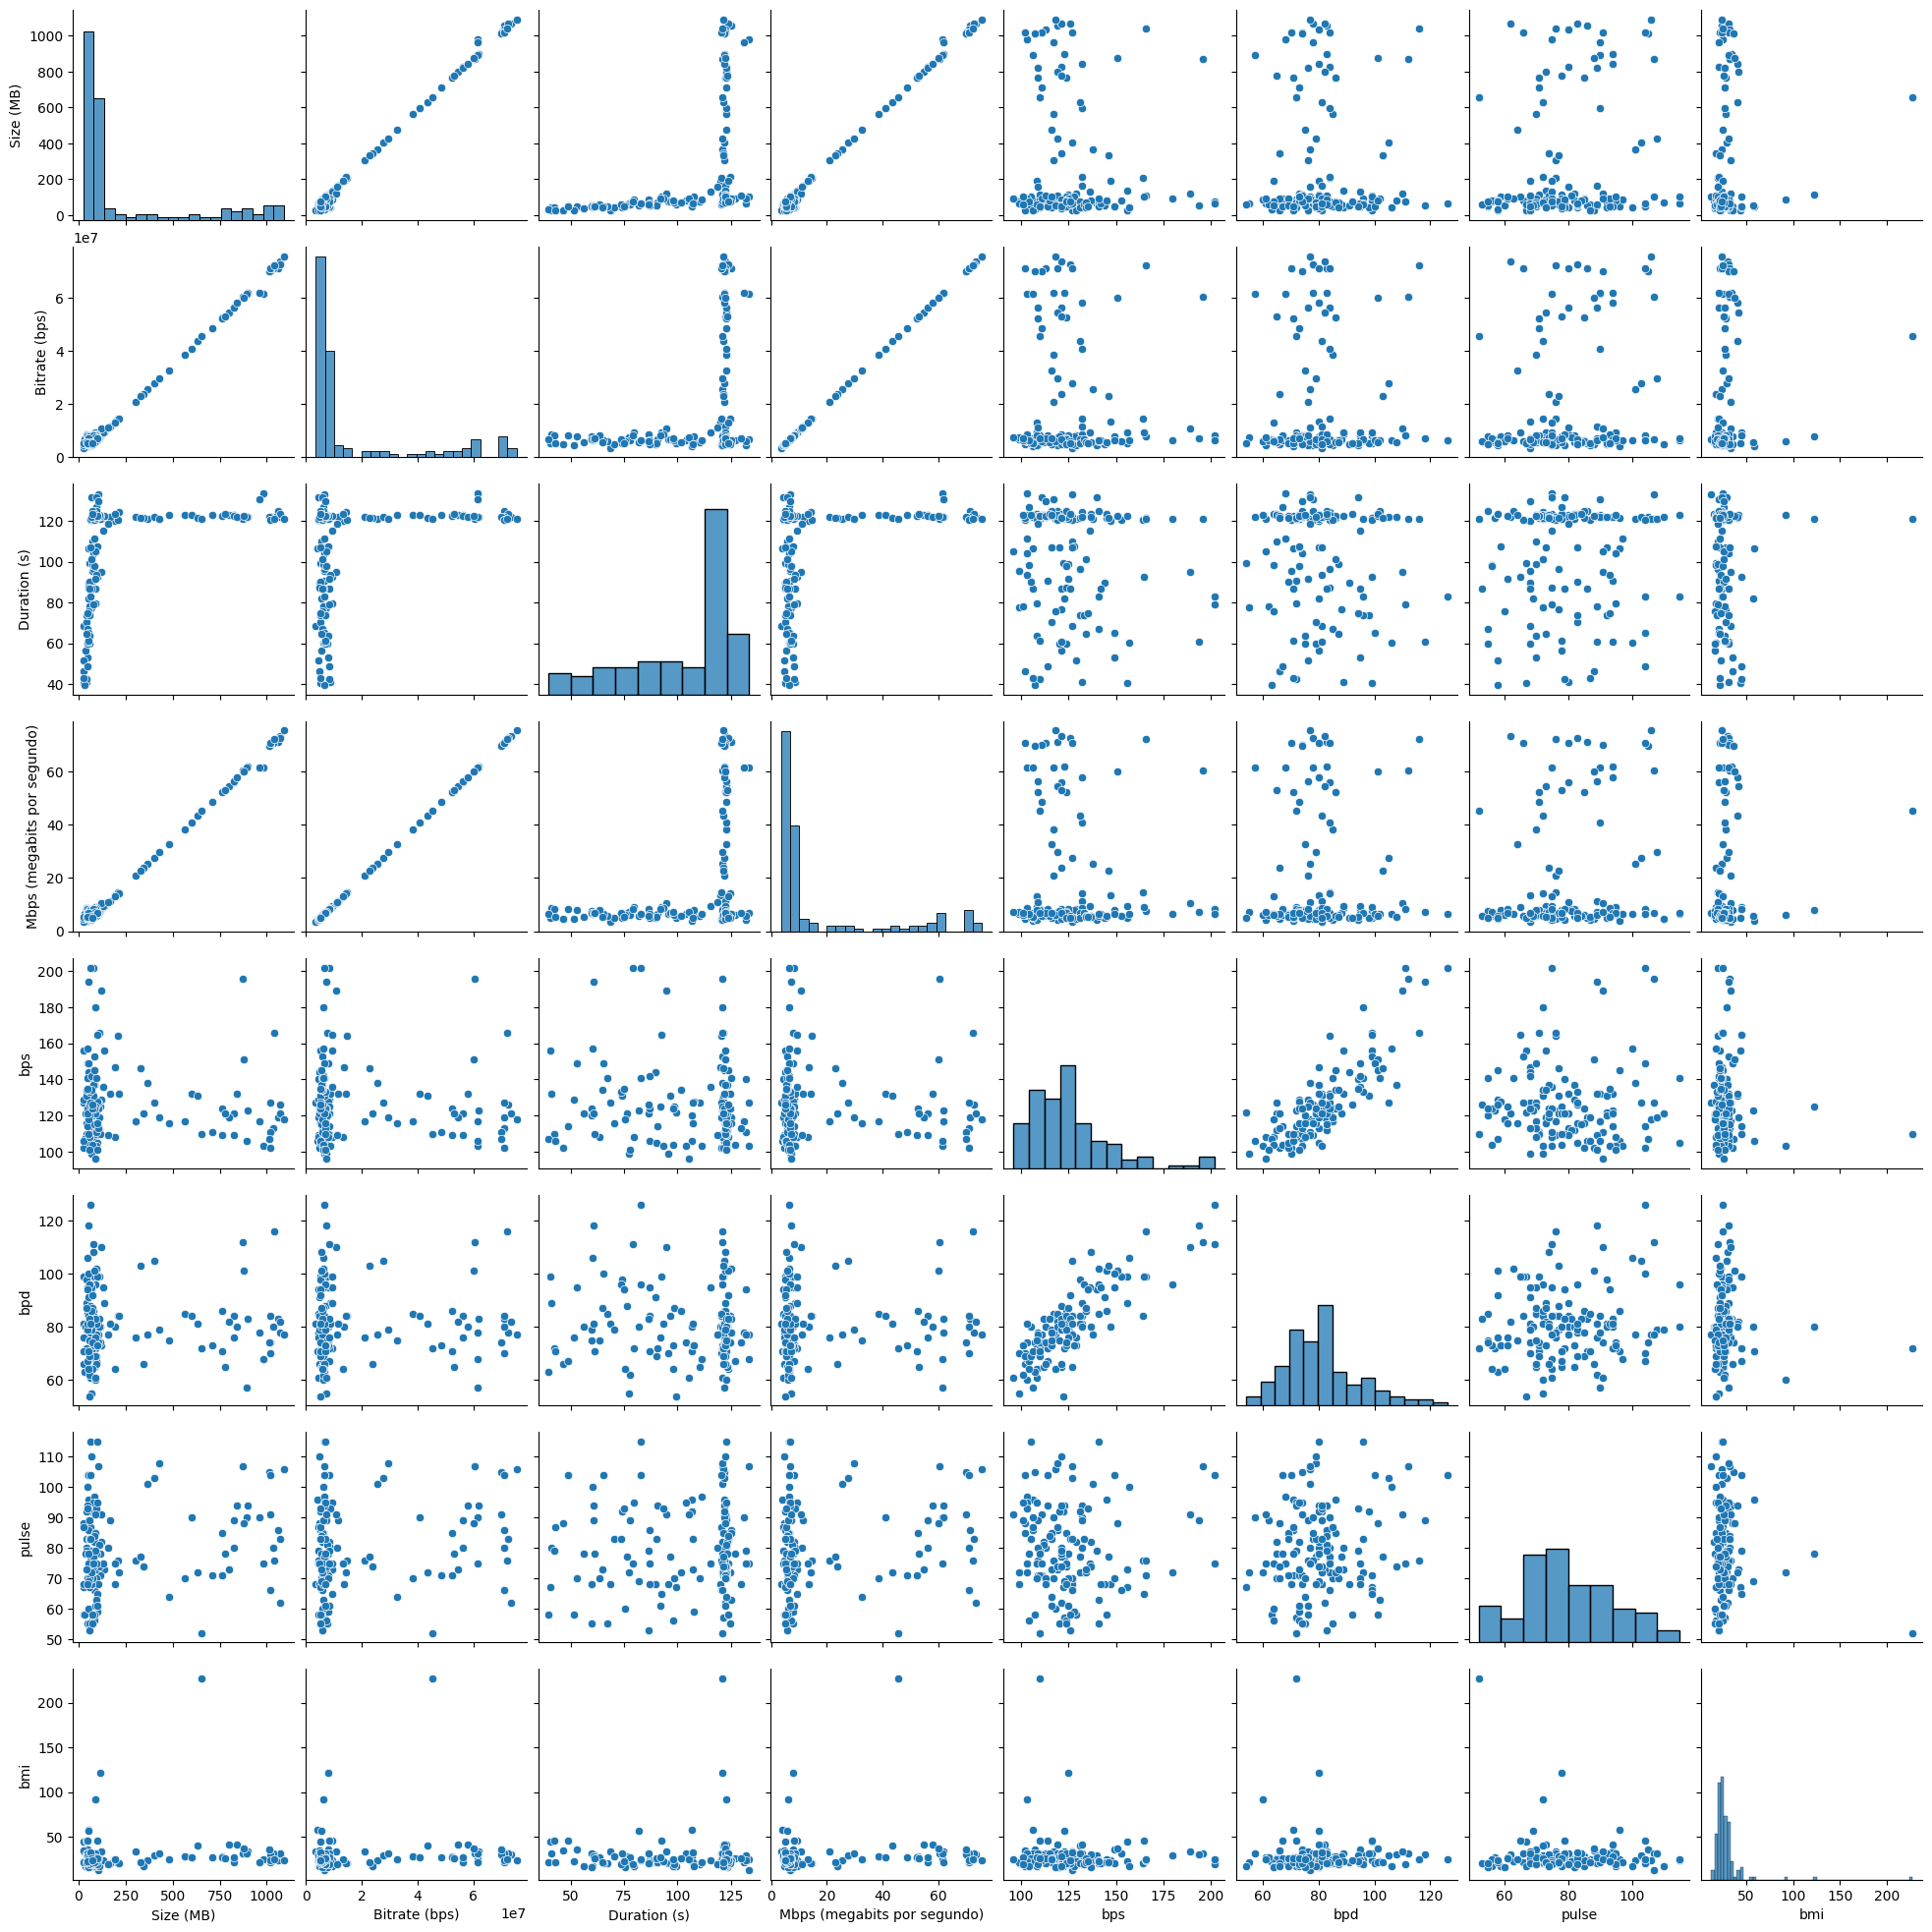

In [15]:
# Pairplot for Video Metadata and Biometric Data
video_cols = ['Size (MB)', 'Bitrate (bps)', 'Duration (s)', 'Mbps (megabits por segundo)']
biometric_cols = ['bps', 'bpd', 'pulse', 'bmi']
sns.pairplot(df[video_cols + biometric_cols])
plt.show()

In [7]:
# Loading video dataset

video_folder = "/content/drive/MyDrive/African_Skintones_VBPE_dataset_filtered_videos"

# Extract video IDs from filenames
video_files = os.listdir(video_folder)
video_ids = set()

for file in video_files:
    match = re.search(r'(?:Copy of )?([A-Z]+\d+)', file)  # Extracts SL124, IN771, SL665
    if match:
        video_ids.add(match.group(1))

# Check for missing videos in the folder
missing_videos = df[~df['id'].astype(str).isin(video_ids)]
print(f"Missing Videos: {missing_videos.shape[0]}")
print(missing_videos)

Missing Videos: 0
Empty DataFrame
Columns: [id, spo2, temperature, bps, bpd, pulse, age, height, weight, gender, bmi, race, category, Filename, Filepath, Duration (s), Size (bytes), Bitrate (bps), Format, Size (MB), Size (GB), Mbps (megabits por segundo)]
Index: []

[0 rows x 22 columns]


In [6]:
# Check for duplicate video IDs in the CSV
duplicate_entries = df[df.duplicated(subset=['id'], keep=False)]
print(f"Duplicate Entries:\n", duplicate_entries)

Duplicate Entries:
 Empty DataFrame
Columns: [id, spo2, temperature, bps, bpd, pulse, age, height, weight, gender, bmi, race, category, Filename, Filepath, Duration (s), Size (bytes), Bitrate (bps), Format, Size (MB), Size (GB), Mbps (megabits por segundo)]
Index: []

[0 rows x 22 columns]


Error: Could not open df_video_metadata_demog_filt.csv
Error: Could not open Input_Image
Error: Could not open df_video_metadata_demog_filt.gsheet
Error: Could not open drive


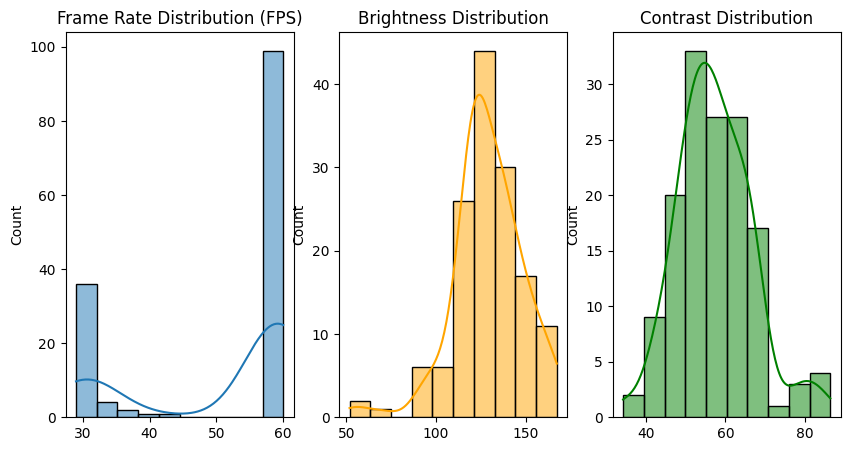

In [17]:
# Video Quality Analysis
frame_rates = []
brightness_levels = []
contrast_levels = []

for file in video_files:
    video_path = os.path.join(video_folder, file)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open {file}")
        continue

    # Frame rate consistency
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_rates.append(fps)

    # Brightness & Contrast
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)  # Average intensity
        contrast = np.std(gray)  # Standard deviation of intensity
        brightness_levels.append(brightness)
        contrast_levels.append(contrast)

    cap.release()

# Plot Frame Rate, Brightness, Contrast Distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
sns.histplot(frame_rates, bins=10, kde=True)
plt.title("Frame Rate Distribution (FPS)")

plt.subplot(1, 3, 2)
sns.histplot(brightness_levels, bins=10, kde=True, color='orange')
plt.title("Brightness Distribution")

plt.subplot(1, 3, 3)
sns.histplot(contrast_levels, bins=10, kde=True, color='green')
plt.title("Contrast Distribution")

plt.show()

**Key Observations**

Frame Rate Distribution (FPS): The histogram shows a bimodal distribution, indicating two dominant frame rates (~30 FPS and ~60 FPS).
This suggests mixed frame rates, possibly due to differences in recording settings, device variations, or processing inconsistencies.

Brightness Distribution: The brightness histogram follows a normal distribution, with most values centered around 100-150.
Indicates consistent lighting conditions, but variations might affect facial feature detection and analysis.

Contrast Distribution: The contrast histogram is slightly right-skewed, peaking around 50-60. Higher contrast levels suggest better feature differentiation, but extreme variations might introduce noise in ROI-based intensity tracking.

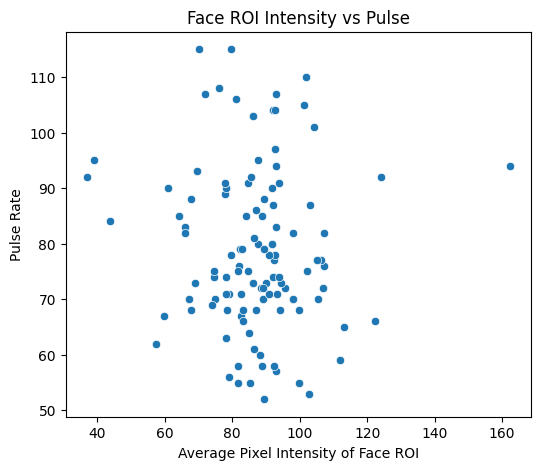


Pearson Correlation (Face Intensity vs Pulse): -0.06090977162579575
Pearson Correlation (Face Intensity vs BPS): 0.04182256214399384
Pearson Correlation (Face Intensity vs BPD): -0.04663934300039367


In [21]:
# Video-Health Data Relationship
# Extract average pixel intensity from face ROI and compare with vitals
face_correlation = []

for file in video_files:
    video_id = re.search(r'(?:Copy of )?([A-Z]+\d+)', file)
    if not video_id:
        continue

    video_id = video_id.group(1)
    video_path = os.path.join(video_folder, file)
    cap = cv2.VideoCapture(video_path)

    ret, frame = cap.read()
    if not ret:
        print(f"Error: Could not read frame for {file}")
        continue

    # Face Detection (Using OpenCV Haar Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_roi = gray[y:y+h, x:x+w]  # Extract face region
        avg_pixel_intensity = np.mean(face_roi)

        # Match with health data
        vital_data = df[df["id"] == video_id][["pulse", "bps", "bpd"]]
        if not vital_data.empty:
            pulse, bps, bpd = vital_data.values[0]
            face_correlation.append([avg_pixel_intensity, pulse, bps, bpd])

    cap.release()

# Convert to DataFrame
face_df = pd.DataFrame(face_correlation, columns=["face_intensity", "pulse", "bps", "bpd"])

# Scatter Plot - Face Intensity vs Pulse
plt.figure(figsize=(6, 5))
sns.scatterplot(data=face_df, x="face_intensity", y="pulse")
plt.title("Face ROI Intensity vs Pulse")
plt.xlabel("Average Pixel Intensity of Face ROI")
plt.ylabel("Pulse Rate")
plt.show()

# Correlation Between Face Intensity and Vitals
print("\nPearson Correlation (Face Intensity vs Pulse):", pearsonr(face_df["face_intensity"], face_df["pulse"])[0])
print("Pearson Correlation (Face Intensity vs BPS):", pearsonr(face_df["face_intensity"], face_df["bps"])[0])
print("Pearson Correlation (Face Intensity vs BPD):", pearsonr(face_df["face_intensity"], face_df["bpd"])[0])

**Key Observations**

There is no strong correlation between pixel intensity and vitals (Pulse, BPS, BPD).

This suggests that raw pixel intensity alone may not be a reliable predictor of vitals.

Need more advaned feature extraction
